# CNN model for Plastic Waste Classification

* #### This notebook trains a Convolutional Neural Network (CNN) to classify different types of images as Oraganic and Recyclable.
* #### It includes loading of dataset, preprocessing, data augmentation, model training, and evaluation.
* #### Other techniques like batch normalization, early stopping and dropout are implemented in the model to optimize the performance.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10683.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10736.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10489.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10512.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10975.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10064.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10281.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10384.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10986.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10870.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10786.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10268.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10760.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10759.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_11008

# Importing necessary libraries


* #### Data manipulation (NumPy, Pandas)
* #### Image processing (OpenCV, Matplotlib)
* #### Deep learning (TensorFlow/Keras)
* #### Performance monitoring (tqdm for progress tracking)


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Suppress warnings for clarity
import warnings
warnings.filterwarnings('ignore')

# Define dataset paths

In [4]:
train_path = "/kaggle/input/waste-classification-data/DATASET/TRAIN"
test_path = "/kaggle/input/waste-classification-data/DATASET/TEST"

In [5]:
# Visualization
from cv2 import cvtColor
x_data = []
y_data = []
for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])
data = pd.DataFrame({'image': x_data, 'label': y_data})


100%|██████████| 12565/12565 [00:50<00:00, 248.99it/s]


In [6]:
data.shape

(22564, 2)

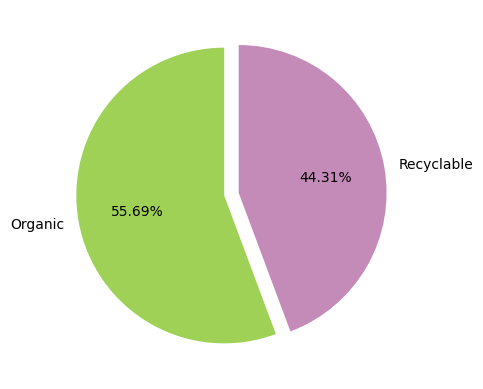

In [7]:
colors = ['#a0d157', '#c48bb8']
plt.pie(data.label.value_counts(), labels=['Organic', 'Recyclable'],        autopct='%0.2f%%',
        colors=colors, startangle=90, explode=[0.05, 0.05])
plt.show()

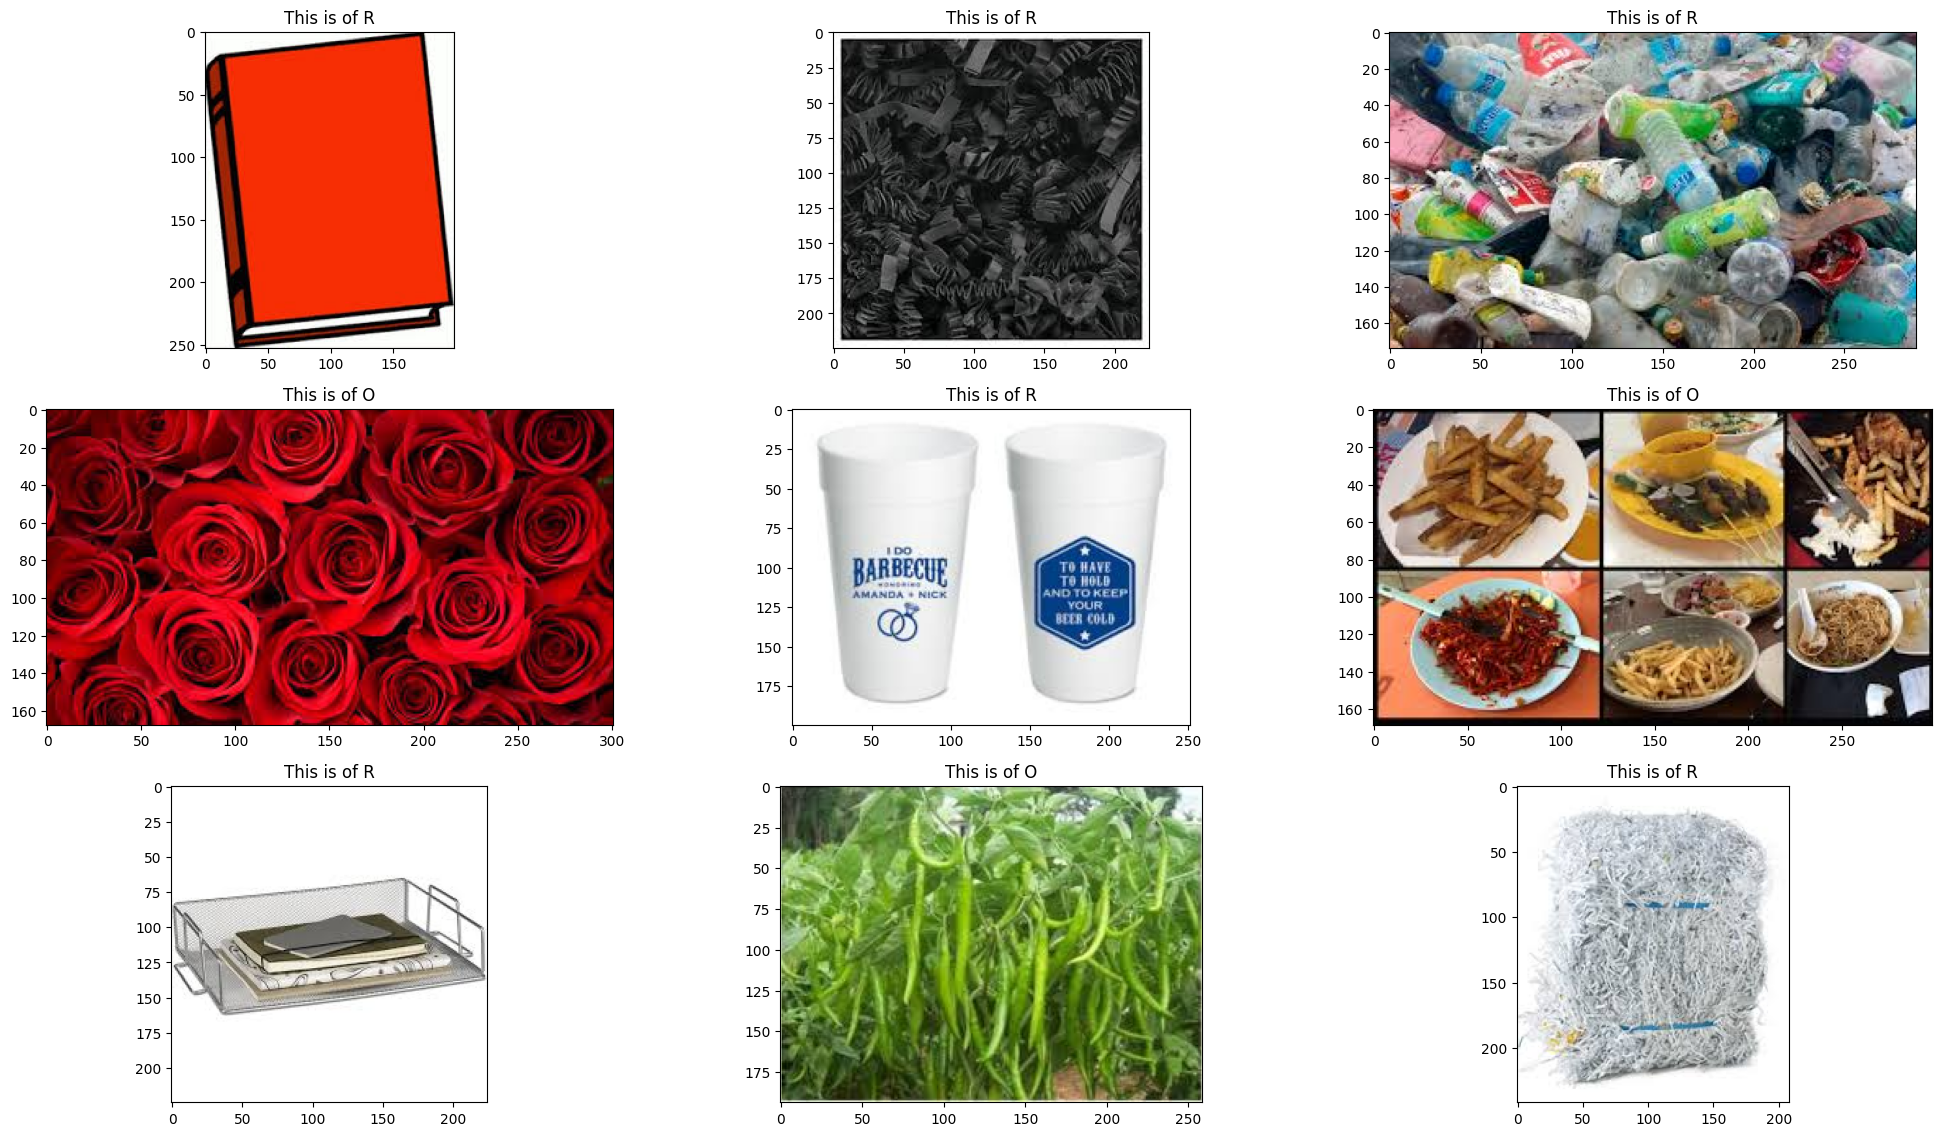

In [8]:
plt.figure(figsize=(20, 15))
for i in range(9):
    plt.subplot(4, 3,(i%12)+1)
    index = np.random.randint(15000)
    plt.title('This is of {0}'.format(data.label[index]))
    plt.imshow(data.image[index])
    plt.tight_layout()

# Improving Generalization with Data Augmentation
### Data augmentation enhances model performance by introducing variations such as rotation, zoom, and flipping, effectively expanding the dataset.

#### Using ImageDataGenerator, we apply:


* rescale: Normalize pixel values to a [0,1] range.
* rotation_range: Randomly rotate images for diversity.
* width_shift_range & height_shift_range: Shift images horizontally and vertically.
* shear_range & zoom_range: Apply shear transformations and zoom effects.
* horizontal_flip: Flip images horizontally to increase variability.
* fill_mode: Fill missing pixels with the nearest values.
* validation_split: Split data into 80% training and 20% validation.


In [9]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Prepare Training and Validation Sets
### We utilize data augmentation to create training and validation datasets for better generalization.


* target_size: Resize images to 224 × 224 pixels.
* batch_size: Set to 32 for efficient training.
* class_mode: Use "categorical" for multi-class classification.
* subset: Specify "training" for the training set and "validation" for the validation set.


In [10]:
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


# Optimized CNN Model Definition
### We design a Convolutional Neural Network (CNN) with the following components:

* Conv2D Layers – Extract key features from input images.
* MaxPooling2D – Reduce spatial dimensions and computational complexity.
* BatchNormalization – Stabilize and accelerate training.
* Flatten Layer – Convert extracted features into a dense format.
* Dense Layers – Learn complex patterns for classification.
* Dropout (50%) – Prevent overfitting by randomly deactivating neurons.









In [47]:
def build_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(len(train_generator.class_indices), activation='softmax')
    ])
    return model

# Compile the CNN Model
* #### Optimizer: Adam with a learning rate of 0.0001 for stable training.
* #### Loss Function: Categorical Crossentropy, ideal for multi-class classification.
* #### Evaluation Metric: Accuracy to measure model performance.

In [48]:
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [49]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 111, 111, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,398,018 (169.36 MB)

 Trainable params: 44,397,570 (169.36 MB)

 Non-trainable params: 448 (1.75 KB)

# Enable Early Stopping and Model Checkpointing
* #### EarlyStopping: Halts training when validation loss no longer improves.
* #### ModelCheckpoint: Stores the best model throughout the training process.

In [50]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)  # Updated file format
]

# Train the CNN model


In [51]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 255s 439ms/step - accuracy: 0.7428 - loss: 2.0141 - val_accuracy: 0.7578 - val_loss: 0.8902
Epoch 2/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 240s 421ms/step - accuracy: 0.7865 - loss: 0.9556 - val_accuracy: 0.7990 - val_loss: 0.6576
Epoch 3/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 241s 423ms/step - accuracy: 0.8120 - loss: 0.6650 - val_accuracy: 0.8214 - val_loss: 0.5748
Epoch 4/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 243s 425ms/step - accuracy: 0.8203 - loss: 0.5642 - val_accuracy: 0.8196 - val_loss: 0.4727
Epoch 5/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 241s 423ms/step - accuracy: 0.8318 - loss: 0.4995 - val_accuracy: 0.8451 - val_loss: 0.4229
Epoch 6/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 237s 415ms/step - accuracy: 0.8366 - loss: 0.4472 - val_accuracy: 0.8045 - val_loss: 0.4941
Epoch 7/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 241s 422ms/step - accuracy: 0.8509 - loss: 0.3911 - val_accuracy: 0.8502 - val_loss: 0.3768
Epoch 8/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 240s 420ms/step - accuracy: 0.8466 -

# Save the trained model

In [52]:
model.save("Waste-Classification-CNN-Model.h5")

# Plot training history
* #### Visualize training and validation performance using Matplotlib.
* #### Accuracy curve shows model improvement.
* #### Loss curve indicates model convergence.

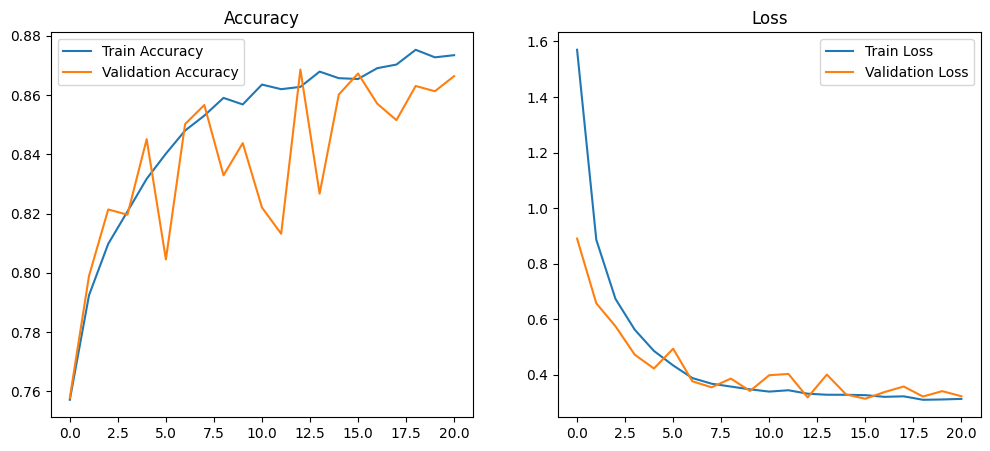

In [53]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

# Load the Trained Model

In [54]:
from tensorflow.keras.models import load_model

model = load_model("Waste-Classification-CNN-Model.h5")

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 111, 111, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,398,020 (169.37 MB)

 Trainable params: 44,397,570 (169.36 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

# Prepare Test Data

* #### Defining the path of the test dataset.
* #### Creating an image generator for rescaling.
* #### Loading the test images in a format similar to the training dataset.

In [55]:
test_path = "/kaggle/input/waste-classification-data/DATASET/TEST"

# Rescale test images to match training data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test dataset with similar preprocessing
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle so that labels remain aligned
)


Found 2513 images belonging to 2 classes.


In [56]:
print(len(test_generator))


79


# Evaluate Model Performance on Test Data

* #### We check how well our model generalizes by testing it on unseen data.

In [57]:
# Evaluate model accuracy on test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9095 - loss: 0.2473
Test Accuracy: 86.39%
Test Loss: 0.3522


# Make Predictions on Test Images

* #### We will predict classes for test images and compare them with true labels.

In [58]:
import numpy as np

# Get predictions (probabilities)
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get actual class labels from test generator
actual_classes = test_generator.classes

# Get class labels (to map indices back to names)
class_labels = list(test_generator.class_indices.keys())

# Print sample predictions
print("Predicted Classes:", [class_labels[i] for i in predicted_classes[:10]])
print("Actual Classes:", [class_labels[i] for i in actual_classes[:10]])


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step
Predicted Classes: ['O', 'O', 'O', 'O', 'R', 'O', 'O', 'O', 'O', 'O']
Actual Classes: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


# Visualize Predictions

* #### We randomly select some test images and display them with predicted labels.

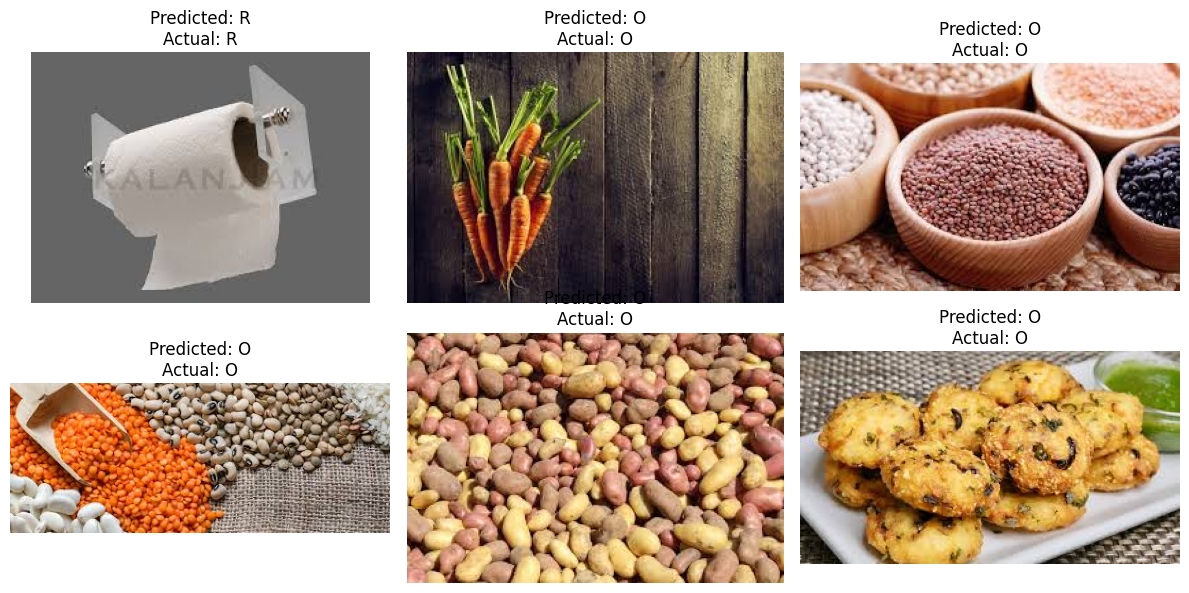

In [59]:
import matplotlib.pyplot as plt

# Get file names for test images
test_image_paths = test_generator.filepaths

# Select random indices
random_indices = np.random.choice(len(test_image_paths), 6, replace=False)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(random_indices):
    img = cv2.imread(test_image_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

    # Get predicted label
    predicted_label = class_labels[predicted_classes[idx]]
    actual_label = class_labels[actual_classes[idx]]

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}", fontsize=12)

plt.tight_layout()
plt.show()


# Classification Report & Confusion Matrix

* #### This helps analyze model performance per class.
  

Classification Report:

              precision    recall  f1-score   support

           O       0.85      0.92      0.88      1401
           R       0.89      0.79      0.84      1112

    accuracy                           0.86      2513
   macro avg       0.87      0.86      0.86      2513
weighted avg       0.87      0.86      0.86      2513



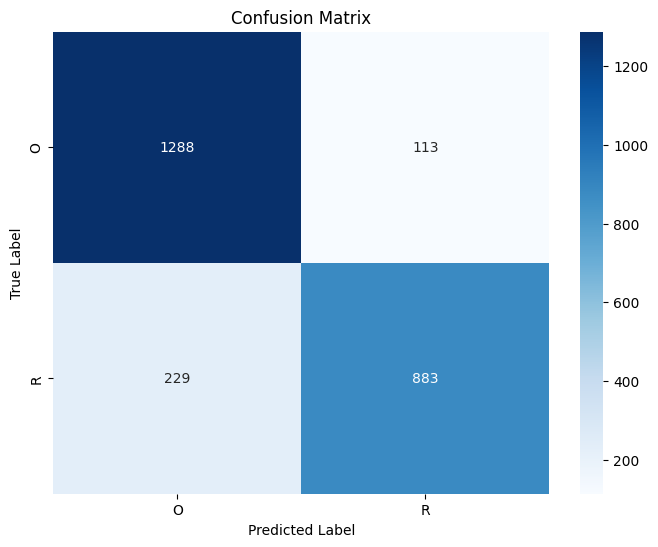

In [60]:
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print("Classification Report:\n")
print(classification_report(actual_classes, predicted_classes, target_names=class_labels))

# Generate and plot confusion matrix
import seaborn as sns

cm = confusion_matrix(actual_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()